In [3]:
import torch
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import train_test_split_edges, to_networkx
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import torch_geometric.transforms as T

In [4]:
name_data = "Cora"
dataset = Planetoid(root='tmp/' + name_data, name=name_data)
dataset.transform = T.NormalizeFeatures()

print(f"Number of Classes in {name_data}: {dataset.num_classes}")
print(f"Number of Node Features in {name_data}: {dataset.num_node_features}")

Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


In [7]:
data = dataset[0]

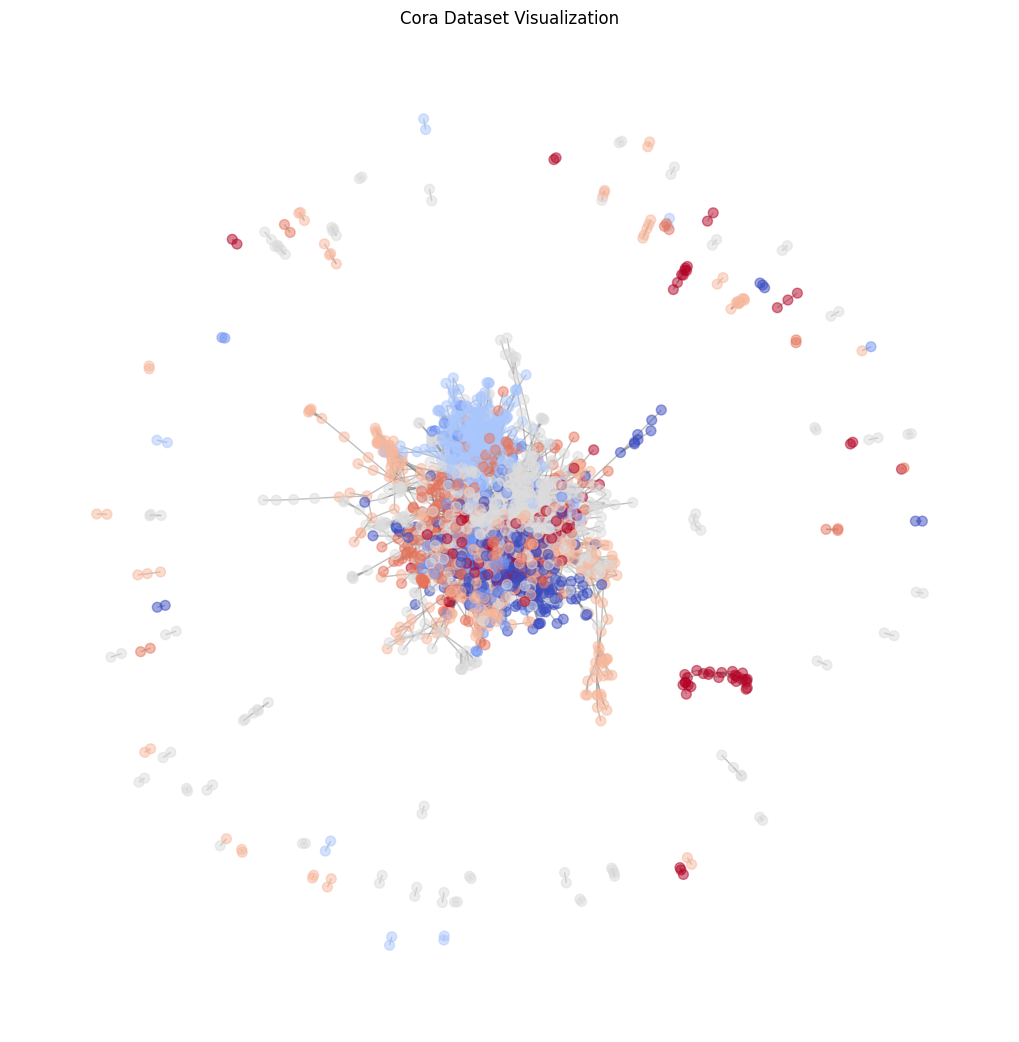

In [10]:
# Improved visualization function
def visualize_graph(data):
    G = to_networkx(data, to_undirected=True)
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, seed=42)  # Use spring layout for better separation
    node_colors = data.y.numpy()
    nx.draw(G, pos, node_size=50, edge_color='gray', alpha=0.5, 
            node_color=node_colors, cmap=plt.cm.coolwarm, with_labels=False)
    plt.title("Cora Dataset Visualization")
    plt.show()

visualize_graph(data)

In [11]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [23]:
# Initialize model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_node_features, 16, dataset.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [24]:
# Train GCN
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 1.9455
Epoch 20, Loss: 1.6440
Epoch 40, Loss: 1.1595
Epoch 60, Loss: 0.7558
Epoch 80, Loss: 0.5292
Epoch 100, Loss: 0.4059
Epoch 120, Loss: 0.3332
Epoch 140, Loss: 0.2861
Epoch 160, Loss: 0.2534
Epoch 180, Loss: 0.2294


In [25]:
# Evaluate GCN
model.eval()
preds = model(data.x, data.edge_index).argmax(dim=1)
acc = accuracy_score(data.y[data.test_mask].cpu(), preds[data.test_mask].cpu())
print(f'GCN Test Accuracy: {acc:.4f}')

GCN Test Accuracy: 0.8040


In [26]:
# Traditional feature-based classifier (Logistic Regression)
x_features = data.x.cpu().numpy()
y_labels = data.y.cpu().numpy()
train_mask = data.train_mask.cpu().numpy()
test_mask = data.test_mask.cpu().numpy()

clf = LogisticRegression(max_iter=500)
clf.fit(x_features[train_mask], y_labels[train_mask])
preds_lr = clf.predict(x_features[test_mask])
acc_lr = accuracy_score(y_labels[test_mask], preds_lr)
print(f'Logistic Regression Test Accuracy: {acc_lr:.4f}')


Logistic Regression Test Accuracy: 0.5740
